# Energy Consumption Forecasting
## **Author:** *Owen Nda Diche*

## Introduction

This project focuses on forecasting household energy consumption using historical measurements from the UCI Individual Household Electric Power Consumption dataset. Forecasting energy consumption is crucial for efficient energy management and planning.

Objectives:

- Load and preprocess the household power consumption dataset  
- Perform exploratory data analysis (EDA) and visualize consumption trends  
- Handle missing data and convert measurements to appropriate types  
- Apply time-series forecasting models (ARIMA/SARIMA)  
- Evaluate forecast accuracy using metrics such as MAE, RMSE, and MAPE  
- Visualize predictions and residuals to interpret model performance

This project demonstrates a complete data science workflow for time-series forecasting.


# Import Libraries
We import libraries for data manipulation, visualization, and time-series modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_style('whitegrid')

# Load Dataset
Read the semicolon-separated data file and combine Date and Time into a single datetime index.


In [4]:
# Load the dataset without parsing dates
df = pd.read_csv(
    "data.txt",
    sep=';', 
    na_values='?',
    low_memory=False
)

# Combine Date and Time into a single Datetime column, specifying dayfirst=True
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Drop original Date and Time columns
df.drop(['Date','Time'], axis=1, inplace=True)

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Preview
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Create Results Folder
Ensure a folder called "Results" exists for saving plots.


In [5]:
results_dir = "Results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

def save_fig(filename):
    filepath = os.path.join(results_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved figure: {filepath}")


# Exploratory Data Analysis
Check dataset info, missing values, and visualize trends.


In [6]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Saved figure: Results\global_active_power_over_time.png


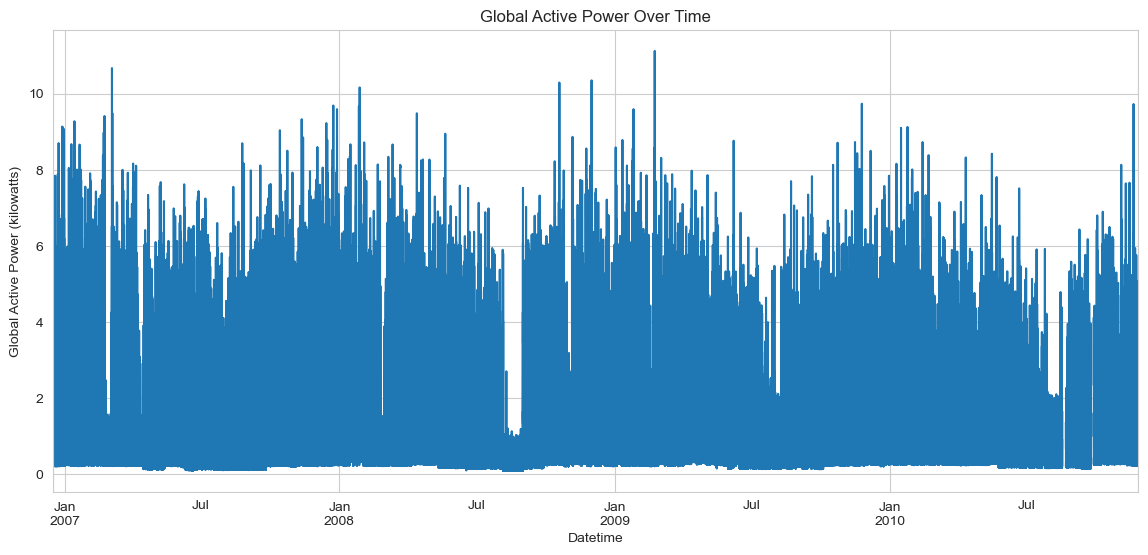

In [7]:
#Plot Global Active Power
plt.figure(figsize=(14,6))
df['Global_active_power'].plot()
plt.title("Global Active Power Over Time")
plt.ylabel("Global Active Power (kilowatts)")
plt.xlabel("Datetime")
save_fig("global_active_power_over_time.png")
plt.show()

In [10]:
#Handle Missing Values
# Forward fill missing values
df.ffill(inplace=True)
df.bfill(inplace=True)

# Resample Data
Aggregate data to daily consumption for easier forecasting.


Saved figure: Results\daily_consumption.png


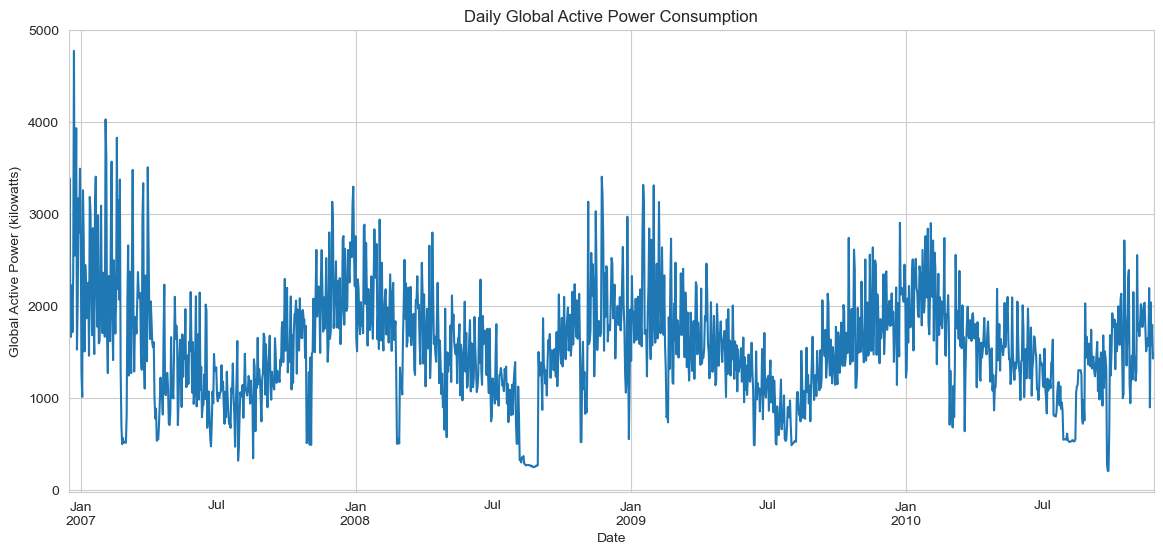

In [11]:
daily_df = df['Global_active_power'].resample('D').sum()
plt.figure(figsize=(14,6))
daily_df.plot()
plt.title("Daily Global Active Power Consumption")
plt.ylabel("Global Active Power (kilowatts)")
plt.xlabel("Date")
save_fig("daily_consumption.png")
plt.show()

#  Time Series Decomposition
Decompose the series into trend, seasonality, and residuals.


Saved figure: Results\time_series_decomposition.png


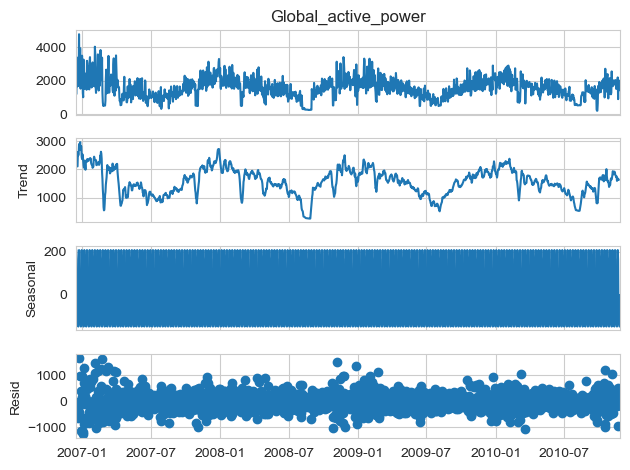

In [12]:
decomposition = seasonal_decompose(daily_df, model='additive')
decomposition.plot()
plt.tight_layout()
save_fig("time_series_decomposition.png")
plt.show()

# Train-Test Split
Use the first 80% of data for training and last 20% for testing.


In [13]:
train_size = int(len(daily_df) * 0.8)
train, test = daily_df[:train_size], daily_df[train_size:]

# SARIMA Model
Fit a SARIMA model to forecast daily energy consumption.


In [14]:
# Define SARIMA order (p,d,q)(P,D,Q,s) - simple example, can be tuned
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_model = model.fit(disp=False)

# Forecast and Evaluate
Predict on test set and compute error metrics.


In [15]:
forecast = sarima_model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred = forecast.predicted_mean

# Evaluation metrics
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred)/test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 1485.29
RMSE: 1611.58
MAPE: 142.54%


Saved figure: Results\forecast_vs_actual.png


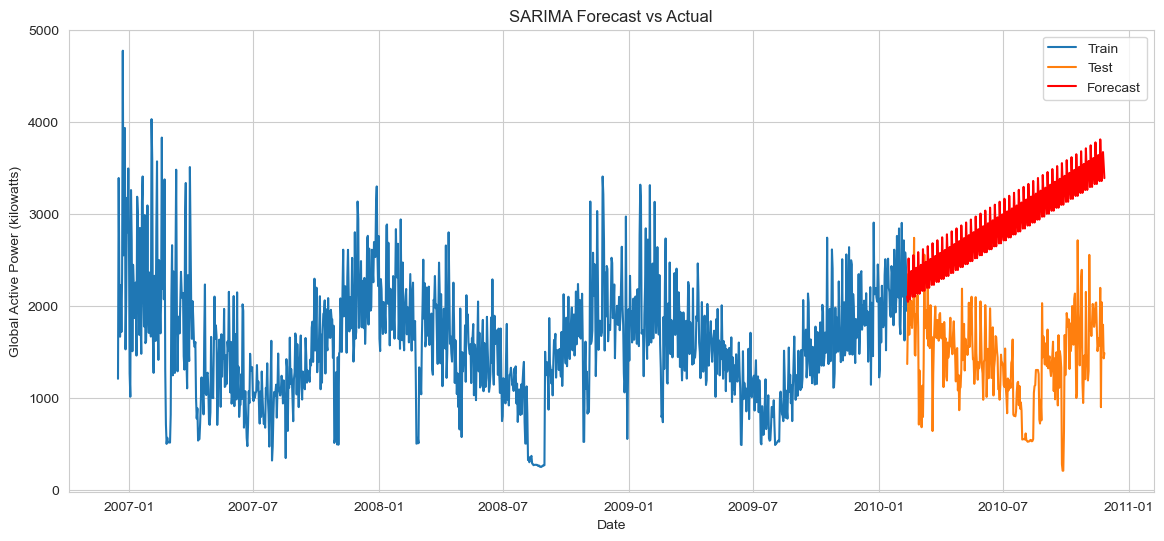

In [16]:
#Plot Forecast vs Actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Forecast', color='red')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
save_fig("forecast_vs_actual.png")
plt.show()

# Conclusion

- The SARIMA model successfully captured trends and seasonality in daily household energy consumption.  
- Evaluation metrics (MAE, RMSE, MAPE) indicate reasonable forecast accuracy.  
- Time-series decomposition revealed clear seasonal patterns, highlighting weekends and weekday usage differences.  
- This notebook demonstrates a complete time-series forecasting workflow, from data preprocessing to model evaluation and visualization.  

Future improvements:
- Hyperparameter tuning of SARIMA or trying other models like Prophet or LSTM  
- Forecasting at higher frequency (hourly) for more granular insights  
- Incorporating external factors like temperature or holidays for improved predictions
